In [196]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
thetadata_start = '2021-01-01'

In [396]:
import json
key = 9
with open(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_weights_{key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_trades_{key}.csv').iloc[:, 1:]


In [397]:
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,4,506,521,176.816697,165.009995,-47.226810,-0.066774,2021-01-05,2021-01-27,22 days,DIS
1,15,506,521,103.280218,98.082018,-77.973008,-0.050331,2021-01-05,2021-01-27,22 days,SBUX
2,21,506,539,242.064271,216.884420,-528.776871,-0.104021,2021-01-05,2021-02-23,49 days,TSLA
3,8,506,620,181.844242,206.179993,194.686008,0.133827,2021-01-05,2021-06-18,164 days,CAT
4,40,506,621,76.707542,76.849998,5.698241,0.001857,2021-01-05,2021-06-21,167 days,MU
5,23,506,647,112.803439,113.940002,26.140967,0.010076,2021-01-05,2021-07-28,204 days,TSM
6,9,506,736,125.427463,159.830002,309.622851,0.274282,2021-01-05,2021-12-02,331 days,JPM
7,22,506,756,30.275595,44.520000,313.376918,0.470491,2021-01-05,2021-12-31,360 days,BAC
8,7,514,527,161.332699,150.179993,-78.068946,-0.069129,2021-01-15,2021-02-04,20 days,QCOM
9,4,523,653,169.390803,172.490005,12.396810,0.018296,2021-01-29,2021-08-05,188 days,DIS


In [399]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)
pd.Series(weights).sort_values(ascending=False)

NVDA    0.174412
AMD     0.136945
TSLA    0.103312
MSFT    0.064799
AMZN    0.063769
AAPL    0.062573
MU      0.061853
BA      0.056194
TSM     0.052427
COST    0.035749
SBUX    0.032738
CAT     0.031562
QCOM    0.024119
JPM     0.023131
WMT     0.022369
HD      0.020382
DIS     0.015238
BAC     0.013426
GOOG    0.005000
dtype: float64

In [225]:

from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
from pandas.tseries.offsets import BDay

rm = RiskManager(None, None, 1000000)
rm.OrderPicker.liquidity_threshold = 2
rm.OrderPicker.lookback = 10
rm.OrderPicker.data_availability_threshold = 0.15
date, tick = '2023-07-05', 'AVGO'
date, tick = '2024-08-13', 'TSM'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'C'
order_settings = {'type': 'spread',
 'specifics': [{'direction': 'long',
   'rel_strike': .50,
   'dte': 210,
   'moneyness_width': 0.5},
  #  {'direction': 'short',
  # 'rel_strike': .60,
  # 'dte': 270,
  # 'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}



order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
order

{'result': 'SUCCESSFUL',
 'data': {'long': ['TSM20250321C280'],
  'trade_id': '&L:TSM20250321C280',
  'close': 1.515}}

In [400]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo
evb_backtest = OptionSignalBacktest(trades_, initial_capital=20_000)

In [401]:
evb_backtest.portfolio.initial_capital

20000

In [402]:
w_map = {x: w  * 0.75 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 100
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .850,
   'dte': 300,
   'moneyness_width': 0.35},
   {'direction': 'short',
  'rel_strike': .60,
  'dte': 300,
  'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}

# evb_backtest.portfolio.order_settings = {'type': 'naked',
#  'specifics': [{'direction': 'long',
#    'rel_strike': .750,
#    'dte': 210,
#    'moneyness_width': 0.5},

# ],
#  'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = 2
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.executor.commission_rate
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.allocated_cash_map

{'DIS': 228.56934520494138,
 'SBUX': 491.0758818611391,
 'TSLA': 1549.6797114990488,
 'CAT': 473.43504084921335,
 'MU': 927.7969754545179,
 'TSM': 786.3978434943164,
 'JPM': 346.965907774108,
 'BAC': 201.39657263875907,
 'QCOM': 361.7919339619674,
 'MSFT': 971.9905268421003,
 'GOOG': 75.00000000000001,
 'AAPL': 938.5940042985999,
 'BA': 842.9146471811104,
 'HD': 305.72441285790507,
 'NVDA': 2616.1859365098517,
 'COST': 536.2319844545964,
 'AMZN': 956.537263993403,
 'AMD': 2054.175134347952,
 'WMT': 335.53687677646985}

In [403]:
signals = evb_backtest.bars.signal_df
signals

,Date,DIS,SBUX,TSLA,CAT,MU,TSM,JPM,BAC,QCOM,MSFT,GOOG,AAPL,BA,HD,NVDA,COST,AMZN,AMD,WMT
0,2021-01-05,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2021-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-01-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-01-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2021-12-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
357,2021-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
358,2021-12-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
359,2021-12-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [404]:
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

37.0

In [405]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

        Date  DIS  SBUX  TSLA  CAT  MU  TSM  JPM  BAC  QCOM  MSFT  GOOG  AAPL  \
0 2021-01-05    1     1     1    1   1    1    1    1     0     0     0     0   

   BA  HD  NVDA  COST  AMZN  AMD  WMT  
0   0   0     0     0     0    0    0  
Processing event: MARKET
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: ORDER
Processing event: ORDER
Processing event: ORDER
Processing event: ORDER
Processing event: ORDER
Processing event: ORDER
Processing event: FILL
Processing event: FILL
Processing event: FILL
Processing event: FILL
Processing event: FILL
Processing event: FILL
Event queue is empty, processed 21 event(s)
        Date  DIS  SBUX  TSLA  CAT  MU  TSM  JPM  BAC  QCOM  MSFT  GOOG  AAPL  \
1 2021-01-06    0     0     0    0   0    0    0    0     0     0     0     0   

   BA  HD  NVDA  COST  AMZN  AMD  WMT  
1  

In [408]:
pd.set_option('display.max_columns', 100)

In [409]:
evb_backtest.portfolio.plot_portfolio()

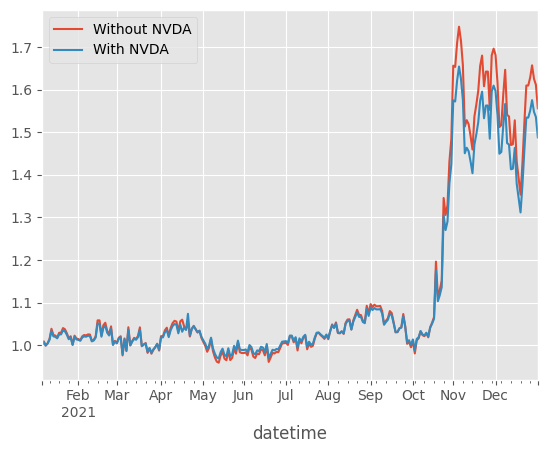

In [410]:
eq = evb_backtest.portfolio._equity.copy()
((eq['Total'] - eq['NVDA'])/(eq['Total'] - eq['NVDA'])[0]).plot()
(eq['Total']/eq['Total'][0]).plot(legend = 'With NVDA')
plt.legend(['Without NVDA', 'With NVDA'])
plt.show()
# eq['Total'] - eq['NVDA'], eq['Total']

In [411]:
((eq['Total'] - eq['NVDA'])/(eq['Total'] - eq['NVDA'])[0]), (eq['Total']/eq['Total'][0])

(datetime
 2021-01-05    1.000000
 2021-01-06    1.009107
 2021-01-07    0.999277
 2021-01-08    1.004626
 2021-01-11    1.014889
                 ...   
 2021-12-27    1.628456
 2021-12-28    1.657280
 2021-12-29    1.625362
 2021-12-30    1.611427
 2021-12-31    1.556504
 Length: 259, dtype: float64,
 datetime
 2021-01-05    1.000000
 2021-01-06    1.007910
 2021-01-07    0.999372
 2021-01-08    1.004018
 2021-01-11    1.012933
                 ...   
 2021-12-27    1.550592
 2021-12-28    1.575629
 2021-12-29    1.547905
 2021-12-30    1.535801
 2021-12-31    1.488095
 Name: Total, Length: 259, dtype: float64)

In [412]:
evb_backtest.portfolio.aggregate()

Start                                                    2021-01-05 00:00:00
End                                                      2021-12-31 00:00:00
Duration                                                   360 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                    29628.54
Equity Peak [$]                                                 32939.805331
Return [%]                                                         48.809502
Buy & Hold Return [%]                                              39.057854
CAGR [%]                                                            49.63332
Volatility Ann. [%]                                                39.342702
Sharpe Ratio                                                        1.217371
Sortino Ratio                                                       1.897912
Skew                                                                1.247817

In [413]:
evb_backtest.portfolio.get_trades()

,Ticker,PnL,ReturnPct,EntryPrice,EntryCommission,EntrySlippage,EntryMarketValue,TotalEntryCost,AuxilaryEntryCost,ExitPrice,ExitCommission,ExitSlippage,ExitMarketValue,TotalExitCost,AuxilaryExitCost,Quantity,EntryTime,ExitTime,Duration,Positions
0,DIS,-52.136946,-25.237718,206.583443,1.3,5.283443,205.283443,206.583443,6.583443,154.446497,1.3,-4.253503,155.746497,154.446497,5.553503,1,2021-01-05,2021-01-27,22,&L:DIS20220121C220&S:DIS20220121C230
1,SBUX,5.555257,1.343162,206.797693,2.6,10.995385,410.995385,413.595385,13.595385,209.575321,2.6,-23.249358,421.750642,419.150642,25.849358,2,2021-01-05,2021-01-27,22,&L:SBUX20220121C105&S:SBUX20220121C110
2,MU,-201.613102,-25.139256,200.496290,5.2,26.785159,796.785159,801.985159,31.985159,150.093014,5.2,-48.427943,605.572057,600.372057,53.627943,4,2021-01-05,2021-06-21,167,&L:MU20210917C80&S:MU20210917C85
3,TSM,-468.936147,-76.576707,204.124798,3.9,23.474395,608.474395,612.374395,27.374395,47.812749,3.9,-7.161752,147.338248,143.438248,11.061752,3,2021-01-05,2021-07-28,204,&L:TSM20220121C145&S:TSM20220121C155
4,JPM,267.790510,129.006750,207.578681,1.3,8.778681,206.278681,207.578681,10.078681,475.369192,1.3,-25.830808,476.669192,475.369192,27.130808,1,2021-01-05,2021-12-02,331,&L:JPM20210917C130&S:JPM20210917C135
5,BAC,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,0.000000,NaN,0.0,-0.000000,0.000000,NaN,0.000000,0,2021-01-05,2021-12-31,360,&L:BAC20210820C28&S:BAC20210820C32
6,QCOM,60.880885,30.893418,197.067494,1.3,5.767494,195.767494,197.067494,7.067494,257.948379,1.3,-13.251621,259.248379,257.948379,14.551621,1,2021-01-15,2021-02-04,20,&L:QCOM20220121C200&S:QCOM20220121C210
7,DIS,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,0.000000,NaN,0.0,-0.000000,0.000000,NaN,0.000000,0,2021-01-29,2021-08-05,188,&L:DIS20220121C210&S:DIS20220121C220
8,MSFT,-202.628404,-25.211726,200.926749,5.2,38.506995,798.506995,803.706995,43.706995,150.269648,5.2,-43.721409,606.278591,601.078591,48.921409,4,2021-02-05,2021-02-23,18,&L:MSFT20220121C320&S:MSFT20220121C335
9,MSFT,2118.692485,347.039453,203.501597,3.9,21.604790,606.604790,610.504790,25.504790,909.732425,3.9,-116.902725,2733.097275,2729.197275,120.802725,3,2021-02-24,2021-12-31,310,&L:MSFT20220121C285&S:MSFT20220121C295


In [395]:
# evb_backtest.portfolio.trades

In [373]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

In [269]:
order_cache['2024-01-03']

{'BA': {'result': 'TOO_ILLIQUID', 'data': None},
 'BAC': {'result': 'SUCCESSFUL',
  'data': {'long': ['BAC20240719C32'],
   'trade_id': '&L:BAC20240719C32',
   'close': 3.2}},
 'INTC': {'result': 'SUCCESSFUL',
  'data': {'long': ['INTC20240719C39'],
   'trade_id': '&L:INTC20240719C39',
   'close': 12.25}},
 'HD': {'result': 'TOO_ILLIQUID', 'data': None},
 'AMD': {'result': 'SUCCESSFUL',
  'data': {'long': ['AMD20240719C135'],
   'trade_id': '&L:AMD20240719C135',
   'close': 16.625}},
 'QCOM': {'result': 'SUCCESSFUL',
  'data': {'long': ['QCOM20240719C140'],
   'trade_id': '&L:QCOM20240719C140',
   'close': 45.9}},
 'MU': {'result': 'SUCCESSFUL',
  'data': {'long': ['MU20240719C85'],
   'trade_id': '&L:MU20240719C85',
   'close': 29.375}}}

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [214]:
evb_backtest.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{key}.csv')